In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
# Geolocation lib
import geopy as gp
from geopy.distance import vincenty
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
# Define some global constants
SHOW_INFO = False
HOME_GPS = np.array([41.864080, -87.624100])
WORK_GPS = np.array([42.059570, -87.674778])
COMMUTE_MIN_TRIP_LEN = 1800 # Minimum trip length in seconds for daily commute trips
COMMUTE_MIN_DST_DIST = 2.0 # Minimum trip destination length in miles
COMMUTE_MAX_TRIP_DIST = 19.0 # Maximum trip distance in miles
CAR_FUEL_TANK_SIZE = 15.9 # Gallons
DATA_MIN_SAMP_SIZE = 300  # minimum trip length is about 5 minutes
DATA_IDLE_MAX_RPM = 780  # maximum Engine RPM of idling
DATA_ENG_LOAD_MAX_GREEN = 18 # Maximum absolute engine load (0xkc) to be qualified as green driving (low or no gas usage)

In [61]:
df = pd.read_csv('raw_logs.csv',header=0).groupby('session')
tripData = pd.DataFrame()
for session, sdf in df:
    dtObj = datetime.fromtimestamp(session/1000.0)
    timeStr = dtObj.strftime('%Y-%m-%d %H:%M:%S')
    
    # Sort by timestamp get the final average MPG for every trip (kff1205)
    sdf = sdf.sort_values('time')
    # Remove invalid values
    sdf = sdf[sdf.kc != 0]
    
    # Ignore session sample size is too small
    if len(sdf.kc.values) < DATA_MIN_SAMP_SIZE:
        continue
    
    # Trip duration
    sts = sdf.time.min()
    ets = sdf.time.max()
    diffTs = ets - sts
    tripLen = diffTs / 1000.0
    # GPS
    gpsLoc = np.array([sdf.kff1006.tolist(), sdf.kff1005.tolist()])
    distHome = np.array([vincenty(gpsLoc[:, 0], HOME_GPS).miles, vincenty(gpsLoc[:, -1], HOME_GPS).miles])
    distWork = np.array([vincenty(gpsLoc[:, 0], WORK_GPS).miles, vincenty(gpsLoc[:, -1], WORK_GPS).miles])
    # Trip distance
    tripDist = sdf.kff1204.max() * 0.62137119223733  # Km to Miles
    # Determine if this is a daily commute trip
    commuteTrip = tripLen > COMMUTE_MIN_TRIP_LEN and tripDist < COMMUTE_MAX_TRIP_DIST and (distHome.min() + distWork.min()) < COMMUTE_MIN_DST_DIST
    # Trip type
    tripType = "commute-" if commuteTrip else "other"
    if commuteTrip:
        tripType += "work2home" if commuteTrip and distHome[0] > distWork[0] else "home2work" 
    # Fuel Usage
    fuelUsed = sdf.kff1271.max() * 0.26417205124156 # L to Gal
    # MPG
    averageMPG = tripDist / fuelUsed
    # Ambient air temp
    airTempList = sdf.k46.tolist()
    airTempValid = np.std(airTempList) > 0
    meanAirTemp = np.nan
    if airTempValid:
        meanAirTemp = np.mean(airTempList)
    # Speed and moving statistics
    speed = sdf.kff1001.values * 0.621371
    meanSpeed = 3600.0 * tripDist / tripLen
    # Engine RPM
    rpm = sdf.kc.values
    ## If the averaged speed from GPS is not too far from actual computed mean
    if rpm.mean() > 0:
        # Compute Moving and Idle ratio
        idleRatio = 100.0 * np.count_nonzero(rpm < DATA_IDLE_MAX_RPM) / len(rpm)
        movingRatio = 100.0 - idleRatio
        # Compute STD of RPM
        stdRPM = np.std(rpm)
    else:
        idleRatio = np.nan
        movingRatio = np.nan
    # Engine Load (Absolute)
    engLoadAbs = sdf.k43.values
    if engLoadAbs.mean() > 0:
        # Percentage of green driving, must qualify:
        #   1. Absolute Engine Load is below threshold
        #   2. Engine RPM is not within the idle range
        greenCnt = np.count_nonzero(np.logical_and(sdf.kc.values > DATA_IDLE_MAX_RPM, sdf.k43.values < DATA_ENG_LOAD_MAX_GREEN))
        greenPct = 100.0 * greenCnt / len(sdf.kc.values)
        # Percentage of time while in Neutral Gear
        neutralCnt = np.count_nonzero(np.logical_and(sdf.kc.values < DATA_IDLE_MAX_RPM, sdf.k43.values < 15))
        neutralPct = 100.0 * neutralCnt / len(sdf.kc.values)
        
    # Dumps information
    if SHOW_INFO:
        print('session {0} ({1}), {2} records'.format(session, timeStr, len(sdf.index)))
        print("---------- Trip type: {0} ----------".format(tripType))
        # Print trip start and end timestamp
        stsStr = datetime.fromtimestamp(sts/1000.0).strftime('%Y-%m-%d %H:%M:%S')
        etsStr = datetime.fromtimestamp(ets/1000.0).strftime('%Y-%m-%d %H:%M:%S')
        print("\t|- Start {0}, end {1}".format(stsStr, etsStr))
        print("\t|- Duration {0} seconds ({1:.2f} minutes)".format(diffTs/1000.0, diffTs/60000.0))
        print("\t|- Distance {0:.2f} miles".format(tripDist))
        print("\t|- Fuel used {0:.3f} gal".format(fuelUsed))
        print("\t|- Average MPG {0:.3f}".format(averageMPG))
        if airTempValid:
            print("\t|- Ambient air temp {0:.2f} degree".format(meanAirTemp))
        if meanSpeed != np.nan:
            print("Mean speed = {0:.3f} MPH, idle ratio = {1:.3f}%".format(meanSpeed, idleRatio))
    else:
        print('Loading session {0} ({1}), {2} seconds ({3:.0f} minutes)'.format(session, timeStr, tripLen, tripLen/60))

    # Save session data
    sessionData = pd.DataFrame({
        'session': session,
        'sTS': sts,
        'eTS': ets,
        'weekday': dtObj.strftime('%a'),
        'airTemp': meanAirTemp,
        'commuteTrip': commuteTrip,
        'tripType': tripType,
        'duration': tripLen,
        'distance': tripDist,
        'fuelUsed': fuelUsed,
        'mpg': averageMPG,
        'idleRatio': idleRatio,
        'movingRatio': movingRatio,
        'meanSpeed': meanSpeed,
        'stdRPM': stdRPM,
        'greenPct': greenPct,
        'neutralPct': neutralPct
        
    }, index=[0])
    sessionData.set_index('session', inplace=True)
    tripData = tripData.append(sessionData)
    
    # Key values
    ### Engine
    ##### k11     =  Throttle Position(Manifold)
    ##### kc      =  Engine RPM
    ##### k46     =  Ambient air temp
    ##### kff1271 =  Fuel used (trip)
    #
    ### Trip
    ##### kff1271 =  Fuel used (trip)
    ##### kff1204 =  Trip Distance
    ##### kff1205 =  Trip average MPG
    #
    ### GPS
    ##### kff1239 =  GPS Accuracy
    ##### kff1010 =  GPS Altitude
    ##### kff123b =  GPS Bearing
    ##### kff1006 =  GPS Latitude
    ##### kff1005 =  GPS Longitude

Loading session 1509673999804 (2017-11-02 20:53:19), 1672.964 seconds (28 minutes)
Loading session 1509715520133 (2017-11-03 08:25:20), 487.987 seconds (8 minutes)
Loading session 1509814879698 (2017-11-04 12:01:19), 462.987 seconds (8 minutes)
Loading session 1510237809601 (2017-11-09 08:30:09), 2658.962 seconds (44 minutes)
Loading session 1510269323150 (2017-11-09 17:15:23), 4439.999 seconds (74 minutes)
Loading session 1510286442413 (2017-11-09 22:00:42), 715.003 seconds (12 minutes)
Loading session 1510290674076 (2017-11-09 23:11:14), 881.999 seconds (15 minutes)
Loading session 1510350680589 (2017-11-10 15:51:20), 352.0 seconds (6 minutes)
Loading session 1510351896342 (2017-11-10 16:11:36), 642.0 seconds (11 minutes)
Loading session 1510356817421 (2017-11-10 17:33:37), 611.001 seconds (10 minutes)
Loading session 1510440698699 (2017-11-11 16:51:38), 444.0 seconds (7 minutes)
Loading session 1510583409805 (2017-11-13 08:30:09), 3019.718 seconds (50 minutes)
Loading session 151058

Loading session 1516631125525 (2018-01-22 08:25:25), 2135.972 seconds (36 minutes)
Loading session 1516663031549 (2018-01-22 17:17:11), 3507.999 seconds (58 minutes)
Loading session 1516717478411 (2018-01-23 08:24:38), 2805.996 seconds (47 minutes)
Loading session 1516746465478 (2018-01-23 16:27:45), 3225.999 seconds (54 minutes)
Loading session 1516836372113 (2018-01-24 17:26:12), 3497.998 seconds (58 minutes)
Loading session 1516890399580 (2018-01-25 08:26:39), 2167.999 seconds (36 minutes)
Loading session 1516922608292 (2018-01-25 17:23:28), 4262.0 seconds (71 minutes)
Loading session 1516977589725 (2018-01-26 08:39:49), 690.955 seconds (12 minutes)
Loading session 1517010325751 (2018-01-26 17:45:25), 1418.982 seconds (24 minutes)
Loading session 1517080588003 (2018-01-27 13:16:28), 1152.349 seconds (19 minutes)
Loading session 1517094013621 (2018-01-27 17:00:13), 2828.988 seconds (47 minutes)
Loading session 1517235961884 (2018-01-29 08:26:01), 3205.194 seconds (53 minutes)
Loading

Loading session 1521034492872 (2018-03-14 08:34:52), 3264.0 seconds (54 minutes)


In [78]:
td = tripData[(tripData.mpg < 40) & (tripData.distance > 3) & (tripData.idleRatio > 0) & (tripData.idleRatio < 75) & (tripData.airTemp != 0.0)]
td.tail(5)
#plt.scatter(td.idleRatio.values, td.mpg.values);

,airTemp,commuteTrip,distance,duration,eTS,fuelUsed,greenPct,idleRatio,meanSpeed,movingRatio,mpg,neutralPct,sTS,stdRPM,tripType,weekday
session,,,,,,,,,,,,,,,,
1520867220994,8.586006,False,7.158301,1418.999,1520868645984,0.277471,32.361516,20.335277,18.160606,79.664723,25.798369,9.475219,1520867226985,414.725654,other,Mon
1520893321013,8.867329,False,4.298381,2853.999,1520896202984,0.273016,22.443016,39.976622,5.421926,60.023378,15.744081,18.176505,1520893348985,469.735472,other,Mon
1520948309347,2.500165,True,16.393627,3149.998,1520951465984,0.682040,20.501816,27.335754,18.735586,72.664246,24.036175,16.110928,1520948315986,462.848445,commute-home2work,Tue
1520976732371,6.190052,True,17.087501,4545.986,1520981283484,0.837973,17.773215,41.318731,13.531719,58.681269,20.391463,22.997947,1520976737498,482.876890,commute-work2home,Tue
1521034492872,1.277796,True,16.834677,3264.000,1521037781984,0.722621,21.519400,24.551679,18.567659,75.448321,23.296692,15.487447,1521034517984,472.284730,commute-home2work,Wed


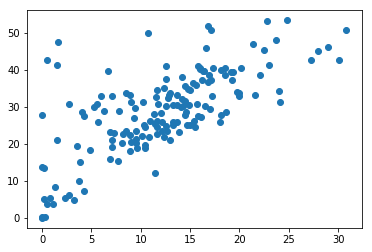

In [82]:
#plt.scatter(td.idleRatio.values, td.mpg.values);
#plt.scatter(td.idleRatio.values, td.tripType.values);
plt.scatter(td.neutralPct.values, td.idleRatio.values);

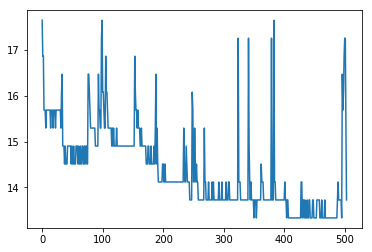

In [77]:
plt.plot(sdf.k43.values[np.logical_and(sdf.kc.values < DATA_MAX_RPM, sdf.k43.values < DATA_ENG_LOAD_MAX_GREEN)]);